# Virus on a Network Reliability Analysis

## Understanding $R_0$ - "R naught"

**Definition:**  
$R_0$ (pronounced "R naught") is the *basic reproduction number*: The expected number of new infections directly generated by one infectious individual in a fully susceptible population.

**Interpretation:**
- $R_0 > 1$: the infection spreads (epidemic growth)  
- $R_0 = 1$: stable (each case replaces itself)  
- $R_0 < 1$: the infection dies out  

**Formula (simplified):**  
$$
R_0 = \beta \times D
$$
where  
- $\beta$ = transmission rate per contact  
- $D$ = duration of infectiousness  

**Intuition:**  
Think of $R_0$ as how "social" a pathogen is in a naive population; a higher $R_0$ means more contagious.

## What is a reliability analysis?

This tutorial will cover the application of a simple reliability analysis on [Virus on a Network](https://mesa.readthedocs.io/latest/examples/basic/virus_on_network.html). The purpose of which is to demonstrate how one can apply calibration procedures to analyse and refine individual mechanistic processes within a simulation model.

The primary aim of a reliability analysis is to compute the probability of any event under uncertainty defined by a threshold or condition:

$$
E = \{ \mathbf{X} \mid g(\mathbf{X}) \le 0 \}
$$

- X = the random input vector, i.e. all the uncertain variables in your system.
- g(X) = the limit state function (or performance function). It defines the boundary between "safe" and "failure" states.

**Examples**

- **Exceeding a threshold:**  
  $g(X) = X_1 + X_2 - 5 → P(X_1 + X_2 > 5)$

- **Inside a safe zone:**  
  $g(X) = X_1^2 + X_2^2 - 1 → P(X_1^2 + X_2^2 \le 1)$

- **Any custom condition:**  
  Define $g(X)$ however you like. calisim just finds the probability that $g(X) \le 0$.

Secondary purposes include:

- **Sensitivity analysis:**  
  Find which inputs most influence reliability (via FORM importance factors).

- **Design optimization:**  
  Adjust parameters to meet a target failure probability.

- **Risk assessment:**  
  Handle multiple failure modes or safety thresholds.

- **Efficient simulation:**  
  Use FORM, importance sampling, or subset simulation  
  to focus on rare or critical events.

## Running Virus on a Network

It is possible to run Virus on a Network from a [Solara dashboard](https://solara.dev/) to get an idea of what our agent-based simulation model looks like.

In [14]:
! solara run voan_app.py --host 0.0.0.0 --port 8765

New version of Solara available: 1.54.0. You have 1.49.0. Please upgrade using:
	$ pip install "solara==1.54.0"
Solara server is starting at http://0.0.0.0:8765
tcgetpgrp failed: Not a tty
/home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/solara/server/starlette.py:522: UserWarning: Cookies with samesite=none require https, but according to the asgi framework, the scheme is 'http'
and the x-forwarded-proto header is 'http'. We will fallback to samesite=lax.

If you embed solara in an iframe, make sure you forward the x-forwarded-proto header correctly so that the session cookie can be set.

See https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/Set-Cookie/SameSite for more information on samesite cookies.

Also check out the following Solara documentation:
 * https://solara.dev/documentation/getting_started/deploying/self-hosted
 * https://solara.dev/documentation/advanced/howto/embed

  warnings.warn(f"""Cookies with samesite=

# Imports

We will first import all required dependencies and specify our constants.

In [37]:
from voan import VirusOnNetwork
from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.reliability import (
	ReliabilityAnalysisMethod,
	ReliabilityAnalysisMethodModel,
)
import numpy as np

N_DAYS = 30
NUM_NODES = 250
AVG_NODE_DEGREE = 3
INITIAL_OUTBREAK_SIZE = 20
VIRUS_CHECK_FREQUENCY = 0.4

reference_virus_spread_chance=0.1
reference_recovery_chance=0.3
reference_gain_resistance_chance=0.5

In [38]:
model = VirusOnNetwork(
    num_nodes = NUM_NODES,
    avg_node_degree = AVG_NODE_DEGREE,
    initial_outbreak_size = INITIAL_OUTBREAK_SIZE,
    virus_spread_chance = reference_virus_spread_chance,
    virus_check_frequency = VIRUS_CHECK_FREQUENCY,
    recovery_chance = reference_recovery_chance,
    gain_resistance_chance = reference_gain_resistance_chance,
)

for _ in range(N_DAYS):
    model.step()
    
reference_state_df = model.datacollector.get_model_vars_dataframe()
reference_state_df

,Infected,Susceptible,Resistant,R over S,Effect R,Contact R-Naught,Proxy Contact R-Naught
0,20,230,0,0.000000,0.000000,0.000000,0.000000
1,22,227,1,0.004405,1.000000,1.013216,0.506608
2,26,221,3,0.013575,1.000000,1.040724,0.684647
3,27,220,3,0.013636,1.000000,1.045455,0.774849
4,27,217,6,0.027650,1.200000,1.271889,0.874257
5,34,209,7,0.033493,1.111111,1.222754,0.932340
6,40,201,9,0.044776,1.000000,1.144279,0.962617
7,45,193,12,0.062176,1.125000,1.340674,1.009874
8,45,190,15,0.078947,1.166667,1.412281,1.054586
9,48,184,18,0.097826,1.000000,1.250000,1.074127


# Calibration procedure

## Reliability Analysis

We will next run the reliability analysis. For this exercise, there are three parameters of interest within Virus on a Network: 

- **virus_spread_chance**: The probability of infection.
- **recovery_chance**: The probability of recovery.
- **gain_resistance_chance**:  The probability of gaining disease resistance.

Let's use a reliability analysis to evaluate how these three parameters impact the estimate of $R_0$. We will compute $R_0$ using the median consensus estimate between two different methods. Firstly, $R_0$ can be calculated directly, as we're modelling transmissions at the individual-level. Secondly, we will use the proxy contact tracing method, as described in [Estimating the reproduction number, R0, from individual-based models of tree disease spread (Wadkin et al., 2024)](https://www.sciencedirect.com/science/article/pii/S030438002400019X)

We will first specify our parameter distributions:

In [48]:
parameter_spec = ParameterSpecification(
    parameters=[
        DistributionModel(
            name="virus_spread_chance",
            distribution_name="uniform",
            distribution_args=[0.08, 0.2],
			data_type=ParameterDataType.CONTINUOUS,
        ),
        DistributionModel(
            name="recovery_chance",
            distribution_name="uniform",
            distribution_args=[0.2, 0.4],
			data_type=ParameterDataType.CONTINUOUS,
        ),
        DistributionModel(
            name="gain_resistance_chance",
            distribution_name="uniform",
            distribution_args=[0.4, 0.6],
			data_type=ParameterDataType.CONTINUOUS,
        )
    ]
)

We will next define our reliability analysis function. We will run the Virus on a Network simulation for 30 days with 250 agents, and subsequently extract the end-of-simulation median consensus estimate of $R_0$ produced by the model.

In [49]:
def reliability_func(
    parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    model = VirusOnNetwork(
        num_nodes = NUM_NODES,
        avg_node_degree = AVG_NODE_DEGREE,
        initial_outbreak_size = INITIAL_OUTBREAK_SIZE,
        virus_spread_chance = parameters["virus_spread_chance"],
        virus_check_frequency = VIRUS_CHECK_FREQUENCY,
        recovery_chance = parameters["recovery_chance"],
        gain_resistance_chance = parameters["gain_resistance_chance"],
    )
    
    for _ in range(N_DAYS):
        model.step()
    
    state_df = model.datacollector.get_model_vars_dataframe()
    end_state = state_df.tail(1)
    r_0 = np.median(end_state[["Contact R-Naught", "Proxy Contact R-Naught"]].values)
    
    return r_0

We will next run the reliability analysis using the Sobol method. Of our many Virus on a Network runs, what is the probability that the estimate of $R_0$ will be greater or equal to 1?

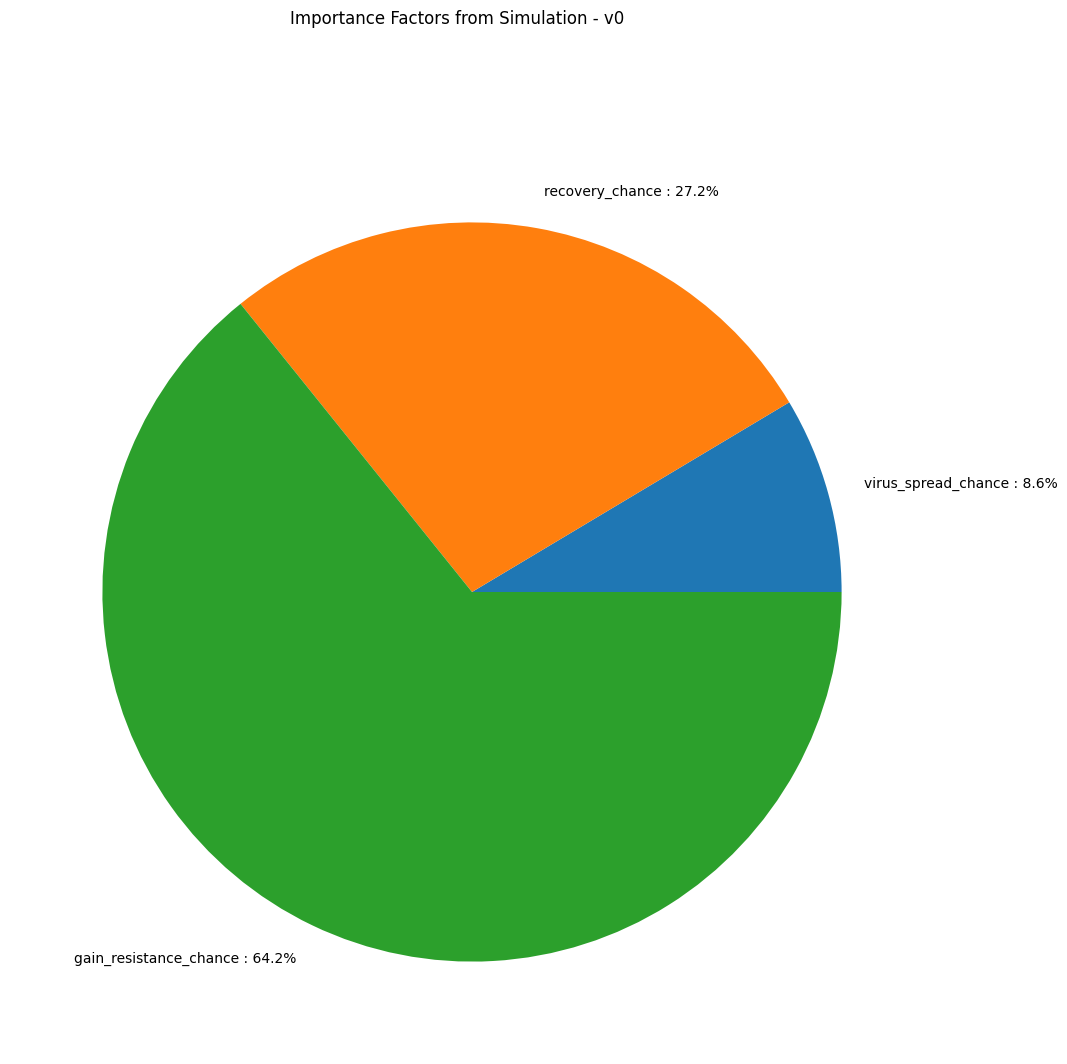

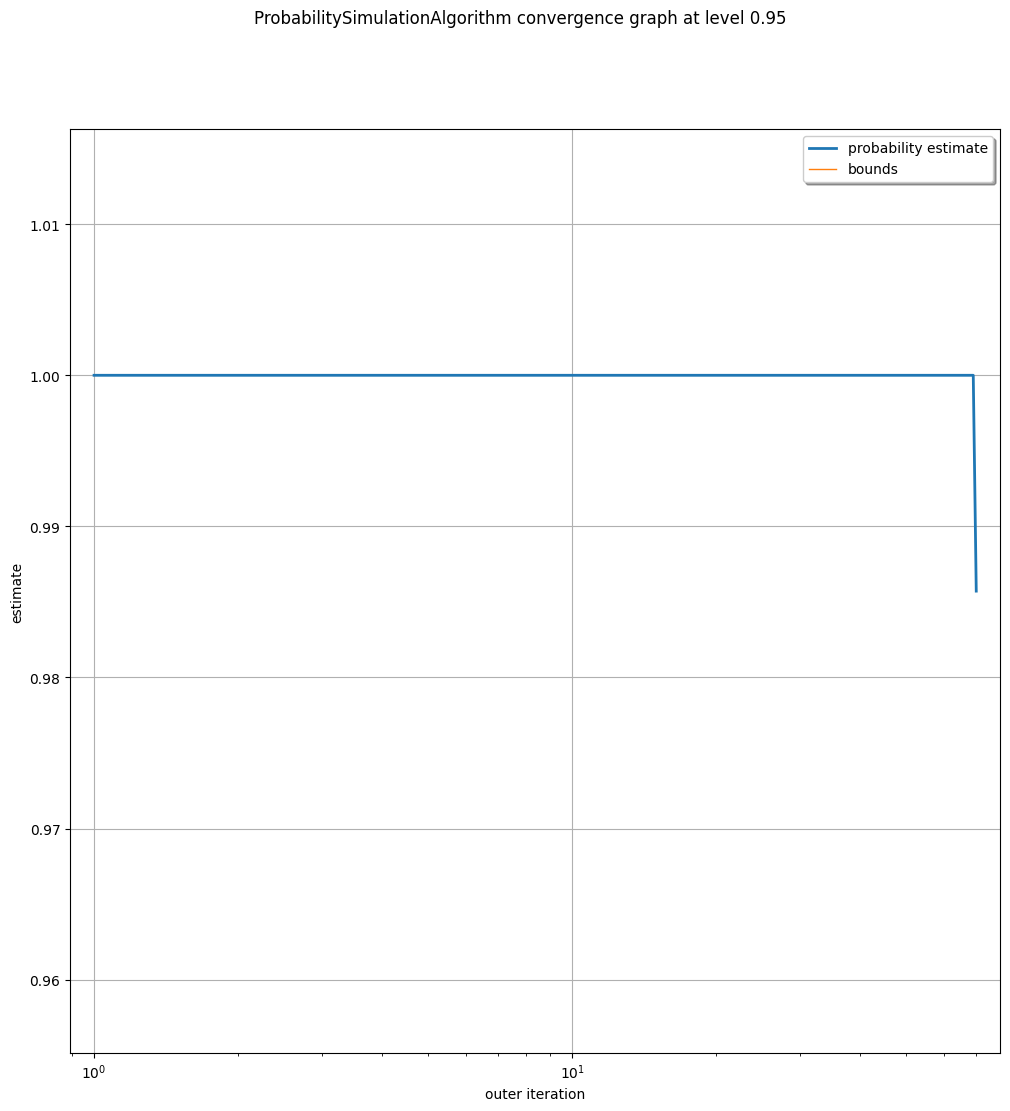

In [50]:
specification = ReliabilityAnalysisMethodModel(
    experiment_name="openturns_reliability_analysis",
    parameter_spec=parameter_spec,
    method="sobol",
	n_samples=100,
	comparison="greater_or_equal",
	threshold=1,
    output_labels=["Median consensus R-Naught"],
)

calibrator = ReliabilityAnalysisMethod(
    calibration_func=reliability_func, specification=specification, engine="openturns"
)

calibrator.specify().execute().analyze()

In [52]:
calibrator.implementation.sampler.getResult()

probabilityEstimate=9.857143e-01 varianceEstimate=2.011662e-04 standard deviation=1.42e-02 coefficient of variation=1.44e-02 confidenceLength(0.95)=5.56e-02 outerSampling=70 blockSize=1

According to these results, the exposure distance is most influential in determnining whether the $R_0$ estimate will be greater or equal to 1.

Noting that our results are stochastic (and that the number of samples is fairly small), according to these results there is roughly an 95% probability that the $R_0$ estimate will be greater or equal to 1.

A future exercise for the interested reader would be to execute more samples for the reliability analysis. In reality, you would want to run several thousands to tens of thousands of simulations, particularly as agent-based models are stochastic and tend to be quite noisy. In addition, you may also be interested in simulating more agents and running the model for longer than 30 days.